##### Version 0.1 Январь 2018

# Источник и сток

Это первый ноутбук из серии *AeroPython*, посвященной изучению классической аэродинамики при помощи Python. Если вы не уверены в своих знаниях основ научных библиотек Python, начните с [*Ликбеза по Python*](00_Lesson00_QuickPythonIntro.ipynb), изложенного во вводном занятии данной серии.

За ходом изложения материала можно следить, просматривая этот ноутбук онлайн, при этом набирая исходный код примеров и упражнений в собственном Jupyter-ноутбуке или в отдельном файле в вашей любимой IDE. В любом случае, необходимо, чтобы приведенные здесь примеры были повторены вами самостоятельно.

## Введение

Классическая аэродинамика основывается на *теории потенциального течения*. Математический аппарат, разработанный в рамках этой теории, был движущей силой аэродинамики в эпоху ее становления в 20 веке.

В её основе лежат некоторые предположения:

* поток стационарный;
* скорости течения много меньше скорости звука (несжимаемая жидкость);
* в жидкости отсутствует трение (идеальная жидкость);
* завихренность также отсутствует (жидкие частицы не вращаются).

Может показаться, что упрощений многовато, но, оказывается, значительная часть течений может быть рассмотена в таких предположениях. Роль вязкости велика лишь в очень тонкой области пограничного слоя, и существуют поправки к потенциальной теории, позволяющие учесть это влияние. Течение во многих практических случаях можно считать безвихревым за исключением изолированных точек, линий или поверхностей. И, наконец, большинство интересующих нас случаев относятся к дозвуковым течениям.

У теории потенциального течения есть одно невероятно удобное математическое свойство: *линейность*. Это означает, что применим принцип суперпозиции, и новые решения можно получать как сумму уже известных.

В этом ноутбуке вы познакомитесь с двумя элементарными потенциальными течениями: **источником** и **стоком**. А затем мы соединим их, и получим еще одно решение.

### Математическая постановка
---

Давайте запишем пару формул. Из курса гидродинамики вам должно быть известно определение *циркуляции*:

$$\Gamma = \oint \mathbf{v}\cdot d\vec{l}$$

По определению, циркуляция это криволинейный интеграл второго рода скорости по замкнутому контуру. Если напрячься, можно вспомнить также теорему Стокса. Она гласит, что криволинейный интеграл по замкнутому равен *потоку ротора* скорости через поверхность, ограниченную этим контуром. Ротор скорости, в свою очередь, это завихренность, $\omega=\nabla\times\mathbf{v}$:

$$\oint \mathbf{v}\cdot d\vec{l} = \int \int_s \omega\cdot \vec{n}~ ds$$

Если завихренность равна нулю (безвихревое течение), то циркуляция по любому замкнутому контуру равна нулю. Это означает, что криволинейный интеграл по любому контуру, соединяющему точки A и B, равен по абсолютному значению и противоположен по знаку интегралу по контуру, соединяющему точки B и A. Раскрыв скалярное произведение вектора скорости $\mathbf{v}=(u,v,w)$, запишем

$$\int_A^B \mathbf{v}\cdot d\vec{l} = \int_A^B u~dx + v~dy + w~dz$$

В безвихревом течении значение этого интеграла не зависит от выбора контура между A и B. А это, как нам должно быть известно из мат. анализа, означает, что $u~dx + v~dy + w~dz~$ является [полным дифференциалом](http://www.wolframalpha.com/input/?i=exact+differential) потенциала $\phi$, где

$$u=\frac{\partial \phi}{\partial x}, \quad v=\frac{\partial \phi}{\partial y}, \quad w=\frac{\partial \phi}{\partial z}$$

Или короче: $\mathbf{v}=\nabla \phi$. Подставив сюда уравнение неразрывности для несжимаемой жидкости $\nabla\cdot\mathbf{v}=0$, мы получим удивительное в своей простоте уравнение потенциального течения:

$$\nabla^2\phi=0$$

*Уравнение Лапласа!* Таким образом любое решение уравнения Лапласа соответствует потенциальному течению.


## Приступим!

Мы хотим получить два решения уравнения Лапласа — потенциалы **источника** и **стока**, для того, чтобы визуализировать поля этих потенциальных течений и насладиться результатом. 

Начнем с импорта нескольких полезных питоновских библиотек:

* NumPy — научная библиотека для работы с многомерными массивами и матрицами;
* Matplotlib — бибилиотека для создания двумерной графики, при помощи которой мы будем визуализировать наши результаты;
* Модуль `math` делает доступными математические функции из стандарта C.

Если вы не помните зачем и как импортировать библиотеки, вернитесь к *вводному занятию*, [Ликбез по Python](00_Lesson00_QuickPythonIntro.ipynb):

In [1]:
import math
import numpy
from matplotlib import pyplot

Наша цель — нарисовать линии тока для источника и стока. Для этого сначала зададим множество точек, в которых будут рассчитаны компоненты скорости. 

Определим декартову сетку, состоящую из равномерно распределённых по расчетной области точек. В качестве расчетной области выберем прямоугольник со сторонами 4 по оси $x$ и 2 по оси $y$: $x,y\in\left[-2,2\right],\left[-1,1\right]$.

Число точек обозначим переменной `N`, а границы расчетной области — переменными `x_start`, `x_end`, `y_start` и `y_end`.

Для создания одномерных массивов, содержащих равномерно распределённые значения по координатам $x$ и $y$ восползуемся функцией [`linspace()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html). В последней строке кода, приведенного в следующем блоке, вызывается функция [`meshgrid()`](http://docs.scipy.org/doc/numpy-1.4.x/reference/generated/numpy.meshgrid.html), создающая двумерные массивы с координатами точек, в которых мы будем вычислять скорости. Убедитесь, что вы понимаете, что делает эта функция и какой результат она возвращает. Мы будем часто её использовать.

In [2]:
N = 50                                # число точек в каждом направлении
x_start, x_end = -2.0, 2.0            # границы по оси x
y_start, y_end = -1.0, 1.0            # границы по оси y
x = numpy.linspace(x_start, x_end, N)    # создает одномерный массив с координатами x
y = numpy.linspace(y_start, y_end, N)    # создает одномерный массив с координатами y

print('x = ', x)
print('y = ', y)

X, Y = numpy.meshgrid(x, y)              # создает сетку

x =  [-2.         -1.91836735 -1.83673469 -1.75510204 -1.67346939 -1.59183673
 -1.51020408 -1.42857143 -1.34693878 -1.26530612 -1.18367347 -1.10204082
 -1.02040816 -0.93877551 -0.85714286 -0.7755102  -0.69387755 -0.6122449
 -0.53061224 -0.44897959 -0.36734694 -0.28571429 -0.20408163 -0.12244898
 -0.04081633  0.04081633  0.12244898  0.20408163  0.28571429  0.36734694
  0.44897959  0.53061224  0.6122449   0.69387755  0.7755102   0.85714286
  0.93877551  1.02040816  1.10204082  1.18367347  1.26530612  1.34693878
  1.42857143  1.51020408  1.59183673  1.67346939  1.75510204  1.83673469
  1.91836735  2.        ]
y =  [-1.         -0.95918367 -0.91836735 -0.87755102 -0.83673469 -0.79591837
 -0.75510204 -0.71428571 -0.67346939 -0.63265306 -0.59183673 -0.55102041
 -0.51020408 -0.46938776 -0.42857143 -0.3877551  -0.34693878 -0.30612245
 -0.26530612 -0.2244898  -0.18367347 -0.14285714 -0.10204082 -0.06122449
 -0.02040816  0.02040816  0.06122449  0.10204082  0.14285714  0.18367347
  0.2244898   0.

Созданную расчётную сетку можно визуализировать при помощи модуля `pyplot` из библиотеки `matplotlib`, используя функцию [`scatter()`](http://matplotlib.org/api/pyplot_api.html?highlight=scatter#matplotlib.pyplot.scatter).

Стоит отметить, что мы довольно детально описываем, как именно должна выглядеть желаемое изображение: мы хотим видеть рисунок определенного размера, с подписями к осям, при этом диапазон на осях тоже задан. Даже [цвет маркеров](http://matplotlib.org/api/colors_api.html?highlight=color#module-matplotlib.colors) определен. Изучив все тонкости документации Matplotlib,  вы научитесь создавать радующие глаз иллюстрации высокого качества.

Для того, чтобы картинки отображались в ноутбуке, вначале нужно использовать [магическую](http://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=magic) комманду `%matplotlib inline`.Тогда результаты работы графического модуля будут вставлены в ноутбук в виде статических изображений в формате PNG:

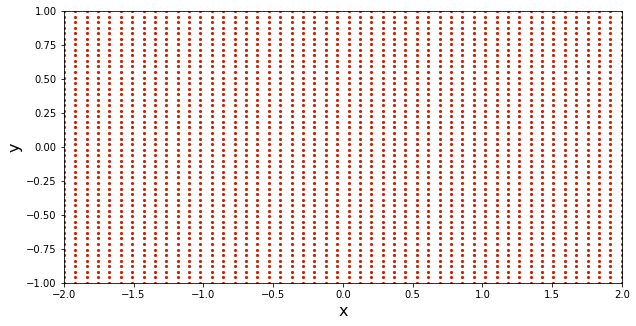

In [4]:
%matplotlib inline

# plot the grid of points
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.scatter(X, Y, s=10, color='#CD2305', marker='o', linewidth=0)

В каждой из этих выстроенных в ряды точек мы теперь вычислим скорсть, соответствующую течению с источником, а затем нарисуем линии тока.

## Источник

We mentioned before the nice quality of potential flow: the governing equation is *linear* and solutions can be built by superposition. For this reason, it is very useful to have a toolbox of elementary solutions that we can use as building blocks. Sources and sinks are such elementary solutions.

A *source* is a point from which we imagine that fluid is flowing out, uniformly. Thus, all the streamlines radiate from a single point as straight lines and the radial velocity decreases with the distance from the source point. Let's consider first the purely two-dimensional case. Because of the radial symmetry, it is convenient to use a cylindrical coordinate system, $\left(r,\theta\right)$. The angle $\theta$ is $\tan^{-1}(y/x)$. The velocity components (radial and tangential) are:

$$u_r\left(r,\theta\right) = \frac{\sigma}{2\pi r} \text{,} \qquad u_\theta\left(r,\theta\right)=0$$

where $\sigma$ represents the source *strength*. That the tangential velocity is zero is obvious from our requirement that the streamlines be radiating straight lines. But how do we get the radial component of velocity? Apply the irrotational-flow condition, $\omega=0$, in cylindrical coordinates, and you will get that the velocity can only be a function of $r$. Then apply the continuity equation, and you will get the result. Try it! (Go on: paper, pencil …)

You probably remember the *stream function* from undergraduate fluid mechanics. But now we are working on cylindrical coordinates. So $\psi$ is obtained from:

$$\frac{1}{r}\frac{\partial\psi}{\partial\theta} = u_r \quad \text{,} \quad -\frac{\partial\psi}{\partial r} = u_\theta$$

which integrates to

$$\psi = \frac{\sigma}{2\pi}\theta + \text{constant}$$

In practical problems, we are more interested in the velocity components that are obtained by differentiation of the stream function, so that the constant can be dropped.

In Cartesian coordinates, the velocity field $\left(u,v\right)$ at position $\left(x,y\right)$ corresponding to a source of strength $\sigma$ located at $\left(x_\text{source},y_\text{source}\right)$ is given by:

$$u = \frac{\partial\psi}{\partial y} = \frac{\sigma}{2\pi}\frac{x-x_\text{source}}{\left(x-x_\text{source}\right)^2+\left(y-y_\text{source}\right)^2}$$

and

$$v = -\frac{\partial\psi}{\partial x} = \frac{\sigma}{2\pi}\frac{y-y_\text{source}}{\left(x-x_\text{source}\right)^2+\left(y-y_\text{source}\right)^2}$$

Let's calculate the velocity field for our grid of points. We'll place the source at the location $(-1,0)$ and give it a strength $\sigma=5$. 

Instead of picking one point on the grid and calculate its velocity (which means that we would have to iterate over all positions `[i,j]`), we directly compute velocity arrays (`u_source`, `v_source`) using arithmetic operators on arrays. Yes, with Numpy, arithmetic operators on array apply elementwise and a new array is created and filled with the result.

In [ ]:
strength_source = 5.0                      # source strength
x_source, y_source = -1.0, 0.0             # location of the source

# compute the velocity field on the mesh grid
u_source = strength_source/(2*math.pi) * (X-x_source)/((X-x_source)**2 + (Y-y_source)**2)
v_source = strength_source/(2*math.pi) * (Y-y_source)/((X-x_source)**2 + (Y-y_source)**2)

Let's plot the stream lines already! We are lucky that the contributors to the open Python world have added a [`streamplot()`](http://matplotlib.org/users/whats_new.html#streamplot) function that does it all. We'll also use the [`scatter()`](http://matplotlib.org/api/pyplot_api.html?highlight=scatter#matplotlib.pyplot.scatter) function to put a red dot right on the source.

In [ ]:
# plot the streamlines
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u_source, v_source, density=2, linewidth=1, arrowsize=2, arrowstyle='->')
pyplot.scatter(x_source, y_source, color='#CD2305', s=80, marker='o', linewidth=0);

Cool. Just like we thought a source should look, only prettier. Note that we added a semicolon on the lastest instruction of the cell above, to suppress the display of the ugly `<matplotlib ...>`, which is just an internal ID for the image. (Notice the `Out[3]` line for the mesh-grid plot: we don't have that now.)

We recommend that after following this notebook carefully, you prepare your own Python code separately, following our example. *Type* the code (instead of copying and pasting), so you assimilate what you are doing. Try things out, change parameters, read the Python documentation when needed. Remember, we will build more complicated flow solutions later on, so be sure to get a good foundation.

##### Challenge question

What is the total mass flux outwards of a small closed surface around the source?

## Сток

In the source flow, the strength $\sigma$ was chosen to be positive. A source with a *negative* strength is called a *sink*. Instead of radiating from a single point, the straight streamlines are now converging to a single point.

The velocity field corresponding to a sink looks similar to that of a source, except for the direction of the flow. Thus, the Python code requires very few modifications.

We will place the sink at the location $(1,0)$ and give it an equal strength to our source, but negative of course.

In [ ]:
strength_sink = -5.0                     # strength of the sink
x_sink, y_sink = 1.0, 0.0                # location of the sink

# compute the velocity on the mesh grid
u_sink = strength_sink/(2*math.pi) * (X-x_sink)/((X-x_sink)**2 + (Y-y_sink)**2)
v_sink = strength_sink/(2*math.pi) * (Y-y_sink)/((X-x_sink)**2 + (Y-y_sink)**2)

In [ ]:
# plot the streamlines
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u_sink, v_sink, density=2, linewidth=1, arrowsize=2, arrowstyle='->')
pyplot.scatter(x_sink, y_sink, color='#CD2305', s=80, marker='o', linewidth=0);

## Пара источник-сток

Now, let's exercise our superposition powers. We already have the velocity field of the source and the velocity field of the sink. We can just add these velocity fields, point wise, to get a new solution of potential flow: the **source-sink pair**. Read this code carefully and make sure you understand what it's doing!

In [ ]:
# compute the velocity of the pair source/sink by superposition
u_pair = u_source + u_sink
v_pair = v_source + v_sink

# plot the streamlines of the pair source/sink
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u_pair, v_pair, density=2.0, linewidth=1, arrowsize=2, arrowstyle='->')
pyplot.scatter([x_source, x_sink], [y_source, y_sink], 
            color='#CD2305', s=80, marker='o', linewidth=0);

Change things around! Move the location of the source and sink, make them stronger. What happens?


##### Challenge task

Write your own code for plotting the *potential lines*, instead of the stream lines. You might want to use the [`contour()`](http://matplotlib.org/examples/pylab_examples/contour_demo.html) function for this.

---

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()